In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math as mt
from tensorflow import keras
from tensorflow.keras import layers
import time
import wandb
import julia
import os
import random as rd
from julia import DynamicalSystems
from julia import Base
from julia import Main
from julia import DifferentialEquations
from matplotlib import rc
%load_ext julia.magic

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Initializing Julia interpreter. This may take some time...


### Energy

In [2]:
E = 0.1
Ename = "01"

----------------------------------------
----------------------------------------
----------------------------------------

In [3]:
Main.E = E

%julia ics_select = []
%julia i = 1
%julia ics = DynamicalSystems.Systems.henonheiles_ics(E, 300)[20000:end]
%julia for ic in ics; if ic[2] > 0.1 && ic[2] < 0.4 && ic[4] > -0.1 && ic[4] < 0.1; push!(ics_select, ic); end; end;
%julia length(ics_select)

3840

In [4]:
start_time = time.time()


x_train = []
y_train = []

for i in range(1,3800,30):
    
    Main.i = i
    %julia T = 2000. ; dt = 0.003
    %julia ds = DynamicalSystems.Systems.henonheiles(ics_select[i])
    %julia x = DynamicalSystems.Systems.trajectory(ds, T, dt = dt)[:,1];
    %julia y = DynamicalSystems.Systems.trajectory(ds, T, dt = dt)[:,2];
    %julia xdot = DynamicalSystems.Systems.trajectory(ds, T, dt = dt)[:,3];
    %julia ydot = DynamicalSystems.Systems.trajectory(ds, T, dt = dt)[:,4];


    x = Main.x.tolist()
    y = Main.y.tolist()
    xdot = Main.xdot.tolist()
    ydot = Main.ydot.tolist()

    Ty=[y[0]]
    Tydot=[ydot[0]]

    #Ty.append(y[0])
    #Tydot.append(ydot[0])

    s = np.sign(x[1])

    for i in range(1,len(x)):

        if np.sign(x[i]) != s:
            if xdot[i]>0:
                Ty.append(y[i])
                Tydot.append(ydot[i])
            s = np.sign(x[i])

    x_train = x_train + [np.array([Ty[i],Tydot[i]]) for i in range(len(Ty)-1)]
    y_train = y_train + [np.array([Ty[i],Tydot[i]]) for i in range(1,len(Ty))]

print("Running time : %s seconds" % (time.time() - start_time))
len(x_train)

Running time : 208.53041338920593 seconds


40788

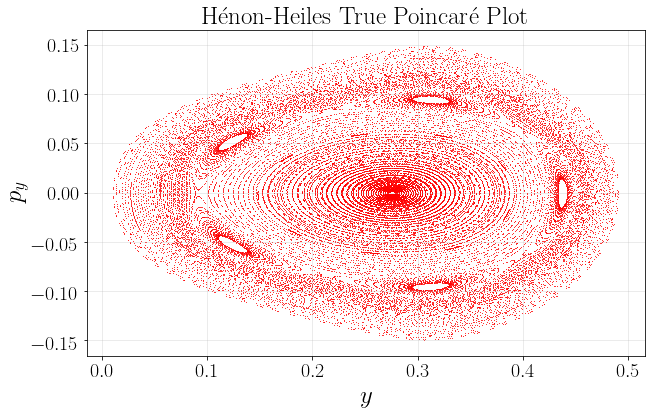

In [12]:
plt.figure(figsize=(10,6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'H\'enon-Heiles True Poincar\'e Plot', fontsize = 25)
plt.scatter(*zip(*x_train), color = "r", label = r'$\mathcal{T}^{2}(x)$, learned', linewidth = 0, s=1)
plt.xlabel(r'$y$', fontsize=25, labelpad=4)
plt.ylabel(r'$p_{y}$', fontsize=25, labelpad=2)
plt.grid(axis='both', alpha=.3)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.xlim(0.1, 0.2)
#plt.ylim(-0.1, 0.1)
#plt.legend(fontsize = 15, loc = 'upper right')
plt.savefig("HenonHeilesPlot")
plt.show()

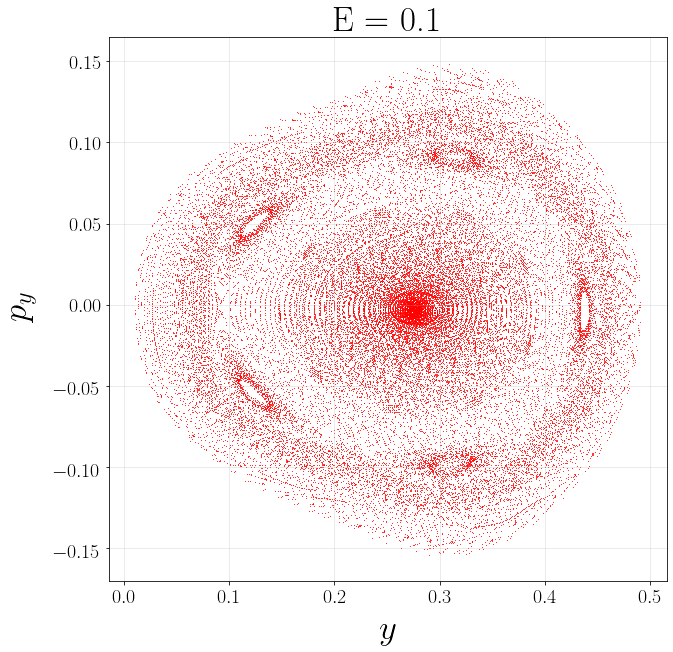

In [13]:
plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'E = ' + str(E), fontsize = 35)
plt.scatter(*zip(*x_train), color = "r", label = r'$\mathcal{T}^{2}(x)$, learned', linewidth = 0, s=1)
plt.xlabel(r'$y$', fontsize=35, labelpad=8)
plt.ylabel(r'$p_{y}$', fontsize=35, labelpad=15)
plt.grid(axis='both', alpha=.3)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.legend(fontsize = 15, loc = 'upper right')
#plt.savefig("HenonHeiles_E01677")
plt.show()

In [20]:
c = list(zip(x_train, y_train))

rd.shuffle(c)

x_train, y_train = zip(*c)

In [21]:
os.remove("x_train_"+ Ename +".txt")
f = open("x_train_"+ Ename +".txt", "a")
for i in x_train:
    f.write(str(i[0]))
    f.write("\n")
    f.write(str(i[1]))
    f.write("\n")
f.close()

In [22]:
os.remove("y_train_"+ Ename +".txt")
f = open("y_train_"+ Ename +".txt", "a")
for i in y_train:
    f.write(str(i[0]))
    f.write("\n")
    f.write(str(i[1]))
    f.write("\n")
f.close()